# Vehicle Detection Project Notebook

In [616]:
# Perform all the imports needed in the notebook

import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time


## Utility functions used in the notebook

In [617]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features    
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def plot_images(images, titles=None, figsize=(12,4), row=None, col=None, gray_cmap='gray'):
    if row==None:
        row = 1
    if col==None:
        col=len(images)
    fig, ax = plt.subplots(row, col, figsize=figsize)
    for i in range(len(images)):
        image = images[i]
        if image.ndim == 3:
            ax[i].imshow(image)
        else:
            ax[i].imshow(image, cmap=gray_cmap)
        if titles != None and len(titles) > i:
            ax[i].set_title(titles[i])

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    #img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
      
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Load Data

In [618]:
car_fnames = glob.glob('./data/vehicles/**/*.*', recursive=True)
notcar_fnames = glob.glob('./data/non-vehicles/**/*.*', recursive=True)
print(len(car_fnames))
print(len(notcar_fnames))

8792
8968


## Explore Data

### Visualize examples of car and not car images

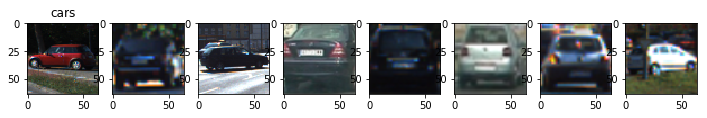

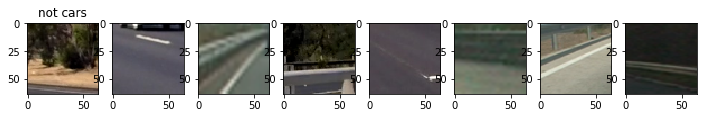

In [619]:
nexamples = 8
car_examples = []
notcar_examples = []
for i in range(nexamples):
    car_ind = random.randint(0, len(car_fnames))
    notcar_ind = random.randint(0, len(notcar_fnames))
    car_examples.append(plt.imread(car_fnames[car_ind]))
    notcar_examples.append(plt.imread(notcar_fnames[notcar_ind]))
plot_images(car_examples, titles=['cars'], figsize=(12,2))
plot_images(notcar_examples, titles=['not cars'], figsize=(12,2))


## Visualize examples of car and not car hog features

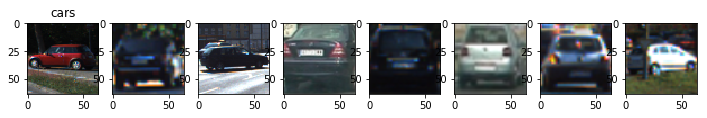

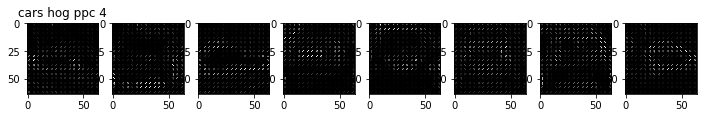

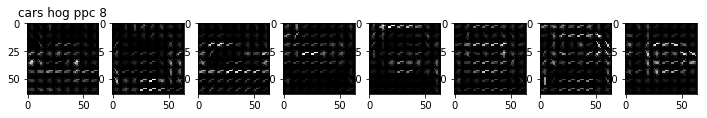

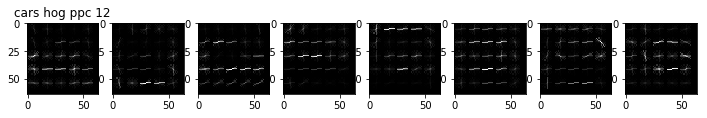

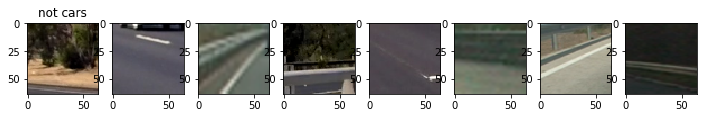

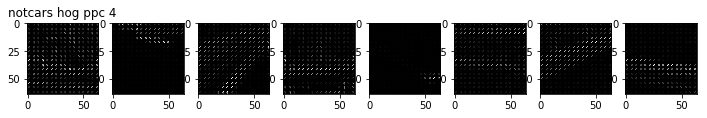

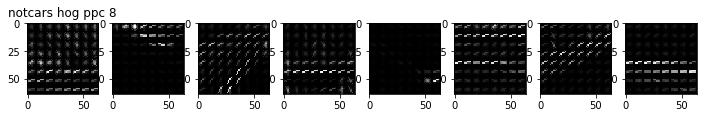

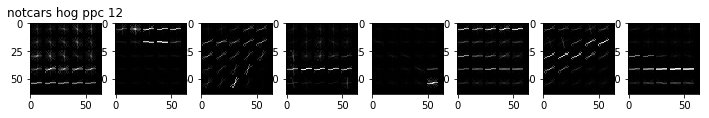

In [620]:
def get_hog_images(images, orient, pix_per_cell, cell_per_block):
    hog_images = []
    for i in range(len(images)):
        gray = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
        hog_images.append(hog_image)
    return hog_images

plot_images(car_examples, titles=['cars'])
plot_images(get_hog_images(car_examples,orient=9,pix_per_cell=4,cell_per_block=2),
            titles=['cars hog ppc 4'])
plot_images(get_hog_images(car_examples,orient=9,pix_per_cell=8,cell_per_block=2),
            titles=['cars hog ppc 8'])
plot_images(get_hog_images(car_examples,orient=9,pix_per_cell=12,cell_per_block=2),
            titles=['cars hog ppc 12'])

plot_images(notcar_examples, titles=['not cars'])
plot_images(get_hog_images(notcar_examples,orient=9,pix_per_cell=4,cell_per_block=2),
            titles=['notcars hog ppc 4'])
plot_images(get_hog_images(notcar_examples,orient=9,pix_per_cell=8,cell_per_block=2),
            titles=['notcars hog ppc 8'])
plot_images(get_hog_images(notcar_examples,orient=9,pix_per_cell=12,cell_per_block=2),
            titles=['notcars hog ppc 12'])


## Visualize spatial bin features

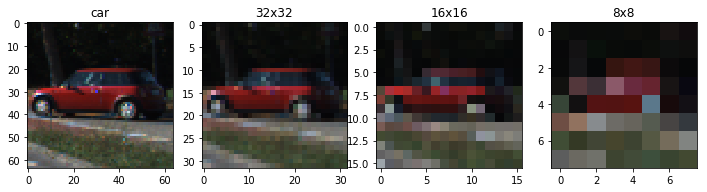

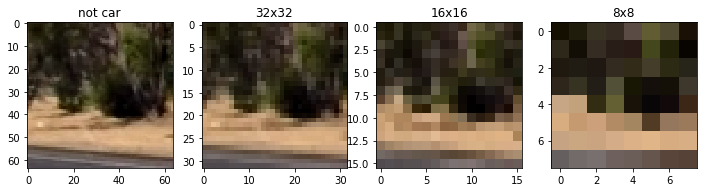

In [621]:
# visualize how much we can down sample the image and still differentiate car and not car

car = car_examples[0]
plot_images([car,cv2.resize(car, (32,32)),cv2.resize(car, (16,16)),cv2.resize(car, (8,8))], 
            titles=['car','32x32','16x16','8x8'])

ncar = notcar_examples[0]
plot_images([ncar,cv2.resize(ncar, (32,32)),cv2.resize(ncar, (16,16)),cv2.resize(ncar, (8,8))], 
            titles=['not car','32x32','16x16','8x8'])
  
    

## Explore and find features for Classifier

In [624]:
# Use a smaller 
sample_size = 1000
car_samples = car_fnames[0:sample_size]
notcar_samples = notcar_fnames[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:')
print('hog_feat', hog_feat,orient,'orientations',pix_per_cell,'pixels per cell and',cell_per_block,'cells per block')
print('hist_feat',hist_feat, 'hist_bins', hist_bins)
print('spatial_feat', spatial_feat, 'spatial_size', spatial_size)
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using:
hog_feat True 9 orientations 8 pixels per cell and 2 cells per block
hist_feat True hist_bins 32
spatial_feat True spatial_size (32, 32)
Feature vector length: 8460
0.55 Seconds to train SVC...
Test Accuracy of SVC =  1.0


## Train a Classifier

In [625]:
# train a classifier using all data

t=time.time()

car_features = extract_features(car_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:')
print('hog_feat', hog_feat,orient,'orientations',pix_per_cell,'pixels per cell and',cell_per_block,'cells per block')
print('hist_feat',hist_feat, 'hist_bins', hist_bins)
print('spatial_feat', spatial_feat, 'spatial_size', spatial_size)
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

68.52 Seconds to extract HOG features...
Using:
hog_feat True 9 orientations 8 pixels per cell and 2 cells per block
hist_feat True hist_bins 32
spatial_feat True spatial_size (32, 32)
Feature vector length: 8460
27.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.01141 Seconds to predict 10 labels with SVC


## Find scale and vertical range to scan for cars

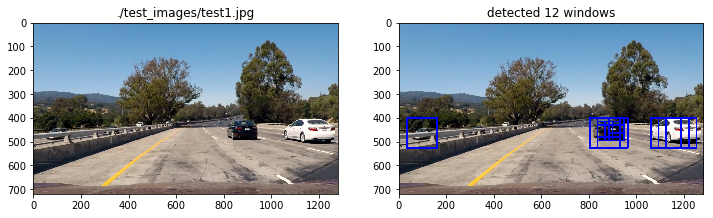

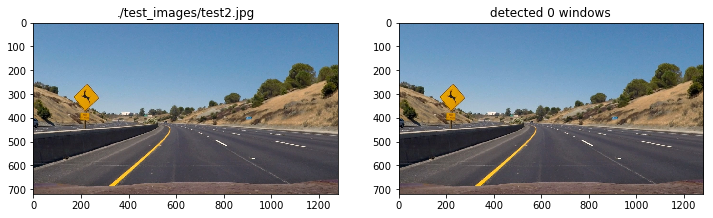

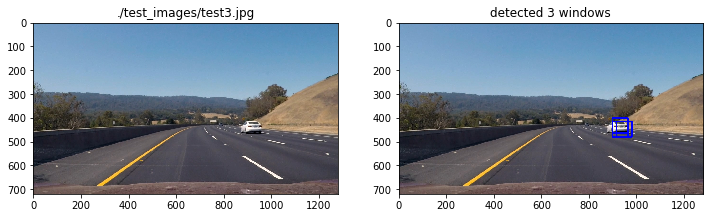

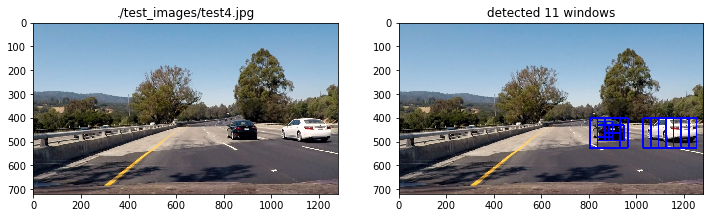

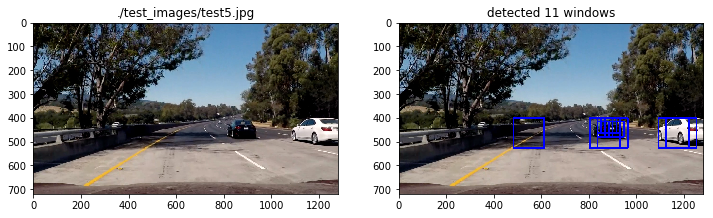

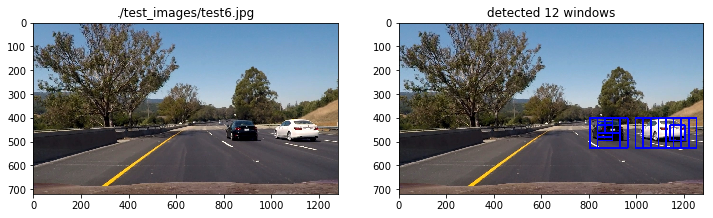

In [675]:
def find_cars(img):
    windows = []
    scale1 = []
    scale2 = []
    scale1 = find_car_windows(img, 400, 680, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    scale2 = find_car_windows(img, 400, 680, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    windows = scale1 + scale2
    return windows

test_images = glob.glob('./test_images/*.jpg')
for file in test_images:
    img = mpimg.imread(file)
    windows = find_cars(img)
    draw_image = draw_boxes(img, windows, color=(0,0,255), thick=6)    
    plot_images([img, draw_image], figsize=(12,12), titles=[file, 'detected {} windows'.format(len(windows))])    
    


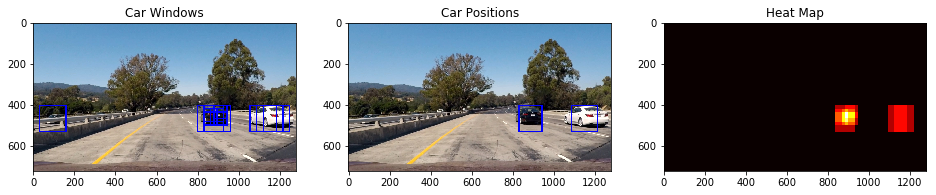

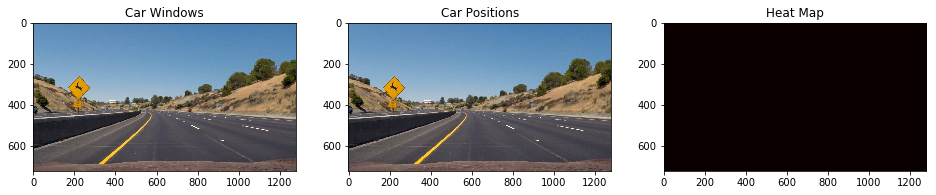

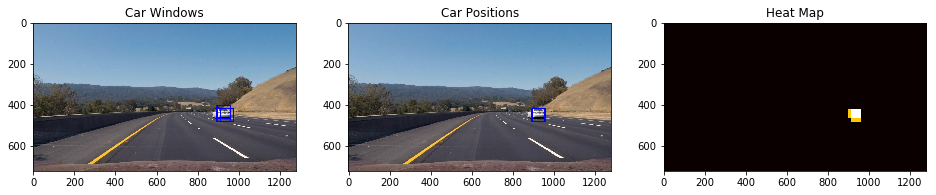

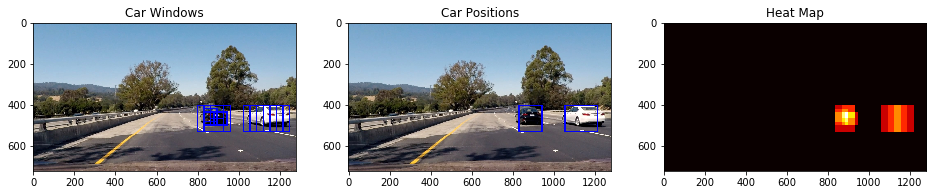

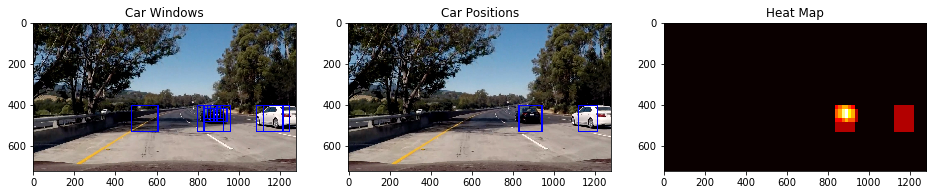

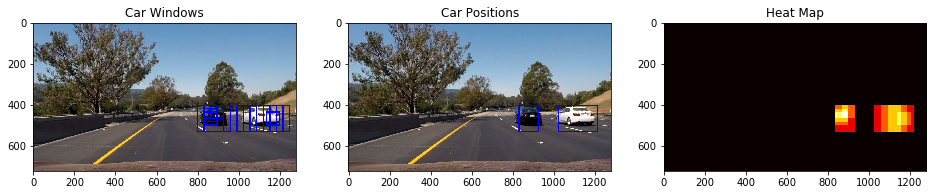

In [676]:
threshold = 1
test_images = glob.glob('./test_images/*.jpg')
for file in test_images:
    img = mpimg.imread(file)
    windows = find_cars(img)
    
    car_image = draw_boxes(img, windows, color=(0,0,255), thick=6)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)    
    
    # Add heat to each box in box list
    heat = add_heat(heat,windows)    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)    

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    plot_images([car_image, draw_img, heatmap], figsize=(16,16), titles=['Car Windows', 'Car Positions', 'Heat Map'], gray_cmap='hot')    


In [670]:
FRAME_HISTORY_SIZE = 10
frame_history = []

def save_history(frame_windows):
    global frame_history
    if len(frame_history) == FRAME_HISTORY_SIZE:
        frame_history.pop(0)
    frame_history.append(frame_windows)  

def get_previous_windows():
    # wait until we have at least 10 frames before we start detecting vehicles
    if len(frame_history) < 10:
        return []
    return [window for frame in frame_history for window in frame]
    
THRESHOLD=3
def process_video_image(img):
    windows = find_cars(img)
    
    save_history(windows)
    
    windows = get_previous_windows()
    
    #car_image = draw_boxes(img, windows, color=(0,0,255), thick=6)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)    
    
    # Add heat to each box in box list
    heat = add_heat(heat,windows)    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,THRESHOLD)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)    

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img



In [671]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = process_video_image(image)
    
    return result

In [673]:

#video_output_file = 'test_video_out.mp4'
#input_video = VideoFileClip("test_video.mp4")

#video_output_file = 'test3_out.mp4'
#input_video = VideoFileClip("test3.mp4")

video_output_file = 'project_video_out.mp4'
input_video = VideoFileClip("project_video.mp4")

output_video = input_video.fl_image(process_image) #NOTE: this function expects color images!!
%time output_video.write_videofile(video_output_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [20:22<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 19min 43s, sys: 41.1 s, total: 20min 24s
Wall time: 20min 23s
